## Lefthandedness & Mortality

Righthanded scissors, righthanded desks, cultural expectations. Lefthanded individuals live in a world designed for right handed individuals. 
According to a 1991 study, the average age of left-handed individuals at death was 9 years lower than the average age of right-handed individuals at death. As a part of the variable 10% of left-handed individuals in the world, this isn't a heartwarming statistic. While this study had its critics due to inaccuracies, it still does leave one to wonder about why the drastic difference in age of death. Is there a relation between handedness and the age at death? While based on personal experience as a left-handed individual, I feel the world may be better suited for right-handed, I hypothesis that the design of this right-handed centric world has evolved for left-handed individuals to adapt to. 

We will be using two datasets in this problem. The first dataset[1] contains lefthanded rates across various ages in the United States. The second dataset[2] contains the death distribution in the United States across various ages. We will first examine the datasets to understand their structure.  

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

death_rate = pd.read_csv("death_rate.tsv", sep = '\t', skiprows = [1])
lefthanded = pd.read_csv("left_handed.csv")

In [10]:
death_rate.head()

,Age,Both Sexes,Male,Female
0,0,27937.0,15646.0,12291.0
1,1,1989.0,1103.0,886.0
2,2,1376.0,797.0,579.0
3,3,1046.0,601.0,445.0
4,4,838.0,474.0,364.0


#### Data Transformation 

In [11]:
lefthanded['Average'] = lefthanded[['Female', 'Male']].mean(axis = 1)
lefthanded.head()

,Age,Male,Female,Average
0,10,12.717558,12.198041,12.457800
1,11,15.318830,11.144804,13.231817
2,12,14.808281,11.549240,13.178760
3,13,13.793744,11.276442,12.535093
4,14,15.156304,11.572906,13.364605


Text(0.5, 1.0, 'Percentage of Lefthanded People Across Ages')

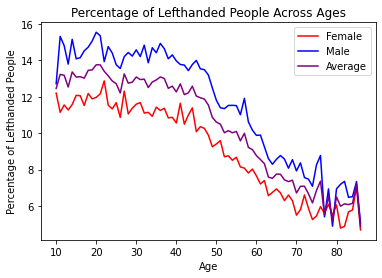

In [12]:
fig, ax = plt.subplots()
ax.plot('Age', 'Female', data = lefthanded, color = 'red')
ax.plot('Age', 'Male', data = lefthanded, color = 'blue')
ax.plot('Age', 'Average', data = lefthanded, color = 'purple')
ax.set_xlabel("Age")
ax.set_ylabel("Percentage of Lefthanded People")
ax.legend()
ax.set_title("Percentage of Lefthanded People Across Ages")

States across certain ages. The percentage rate varies between 6% and 16%. We can see that across the older ages, the percentage of lefthanded individuals decreases.

Text(0.5, 1.0, 'Rate of Lefthandedness Across Years')

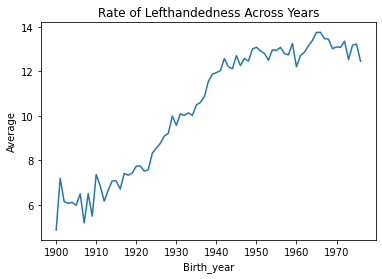

In [13]:
lefthanded['Birth_year'] = 1986 - lefthanded['Age']
fig, ax = plt.subplots()
ax.plot('Birth_year', 'Average', data = lefthanded) 
ax.set_xlabel('Birth_year') 
ax.set_ylabel('Average')
ax.set_title("Rate of Lefthandedness Across Years")

The dip in the previous plot can be explain by looking at this plot which is a plot of the rate of left-handedness across years. This plot displays individuals within each year that are left-handed. Between 1900 and 1920, fewer lefthanded births were accounted for meaning less individuals of an older age in the future.

In [14]:
death_rate = death_rate.drop(index= death_rate.index[0], axis = 0)  ###remove the top column which describes total
death_rate.rename(columns = {"Both Sexes" : "Total Deaths"}, inplace = True)
death_rate = death_rate.dropna(subset = ["Total Deaths"])
death_rate.head()

,Age,Total Deaths,Male,Female
1,1,1989.0,1103.0,886.0
2,2,1376.0,797.0,579.0
3,3,1046.0,601.0,445.0
4,4,838.0,474.0,364.0
5,5,763.0,446.0,317.0


To better understand the problem, the probability of living to a certain age A is calculated based on the death distribution dataset. This dataset provides us with the number of people who died in a year and their age at the time of death. The dataset represents the United States to the turn of the century. Below is a plot of the death distribution across ages.

Text(0.5, 1.0, 'Death Distribution Across Ages')

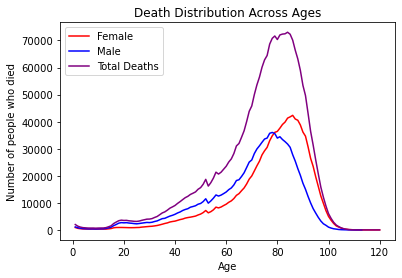

In [15]:
fig, ax = plt.subplots()
ax.plot('Age', 'Female', data = death_rate, color = 'red')
ax.plot('Age', 'Male', data = death_rate, color = 'blue')
ax.plot('Age', 'Total Deaths', data = death_rate, color = 'purple')
ax.legend()
ax.set_xlabel("Age")
ax.set_ylabel("Number of people who died")
ax.set_title("Death Distribution Across Ages")

Furthermore, to better understand the problem, the probability of living to a certain age A is calculated based on the death distribution dataset. This dataset provides us with the number of people who died in a year and their age at the time of death. The dataset represents the United States to the turn of the century. Above is a play which displays the death distribution across ages.

### Bayes Rule

The goal is to calculate the probability of dying at a certain age if you are left-handed. This probability can be written as  P(A | LH) and compare it to the probability of dying at a certain age if you are right-handed which is P(A | RH).

To compare this, Bayes' Theorem about conditional probability will be used.

Bayes' theorem for these events can be written as follows:

𝑃(𝐴|𝐿𝐻)= 𝑃(𝐿𝐻|𝐴)𝑃(𝐴)/𝑃(𝐿𝐻) where P(LH | A) is the probability that you are left-handed given that you died at a certain age, and P(LH) is the overall probability of being left-handed, and P(A) is the probability of dying at age A.

The death distribution and lefthandedness datasets have different age ranges. Death distribution has age ranges from 1 to 120 while the lefthandness dataset has age ranges 10 to 86. We will need to predict the lefthandedness rates for the missing age ranges. We will use an average of nearby datapoints to extrapolate the missing fields and derive the probability of left handedness given age at death. 

In [16]:
def Prob_lefthanded_Age(death_age, year = 1992):
    
    before = lefthanded['Average'][-10:].mean()
    after = lefthanded['Average'][:10].mean()
    middle = lefthanded.loc[lefthanded['Birth_year'].isin(year - death_age)]['Average']
    
    youngest = year - 1986 + 10
    oldest = year - 1986 + 86
    
    Probability = np.zeros(death_age.shape)  
    Probability[death_age > oldest] = before / 100
    Probability[death_age < youngest] = after / 100
    Probability[np.logical_and((death_age <= oldest), (death_age >= youngest))] = middle / 100
 
    return Probability

As a next step in calculating the conditional probability, the probability of dying in a given year and being lefthanded is derived. This value is reached by adding left-handedness probabilities for each age and weighting them with the number of deaths at each age. This value is then divided by the total number of deaths. 

In [17]:
def Prob_lefthanded(death_rate, year = 1992):
    prob = Prob_lefthanded_Age(death_rate['Age'], year) * death_rate['Total Deaths']
    Probability = np.sum(prob)
    Probability = Probability / np.sum(death_rate['Total Deaths'])
    return Probability

print(Prob_lefthanded(death_rate))

0.079001622686629


The conditional probability can now be derived since P(LH | A), the probability that you are left-handed, P(LH), the overall probability of being left-handed, and P(A), the probability of dying at age A have been calculated.

In [18]:
def Prob_Age_given_lefthanded(death_age, death_rate, year = 1992):
    P_A = death_rate['Total Deaths'][death_age] / np.sum(death_rate['Total Deaths'])
    P_LH = Prob_lefthanded(death_rate, year) 
    P_LH_A = Prob_lefthanded_Age(death_age, year)
    cond_prob = P_LH_A * P_A / P_LH
    return cond_prob

The probability of dying at a certain age if you are right-handed (P(A | RH)) can also be derived as seen below. 

In [19]:
def Prob_Age_given_righthanded(death_age, death_rate, year = 1992):
    P_A = death_rate['Total Deaths'][death_age] / np.sum(death_rate['Total Deaths'])
    P_RH = 1 - Prob_lefthanded(death_rate, year) 
    P_RH_A = 1 - Prob_lefthanded_Age(death_age, year)
    cond_prob_RH = P_RH_A * P_A / P_RH
    return cond_prob_RH

The conditional probability can be plotted for the probability of being a certain age at death given that you are left or right-handed. In the plot below, it seems that between the ages of 60 and 90, the probability of being at those ages at death is lower than right-handed individuals. This can indicate that between these age ranges, left-handed individuals tend to be younger than right-handed individuals. 

Text(0.5, 1.0, 'Conditional Probability of An Age at Death in 1992')

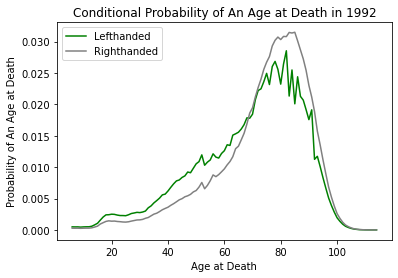

In [20]:
age_range = np.arange(6, 115, 1)
lh_prob = Prob_Age_given_lefthanded(age_range, death_rate)
rh_prob = Prob_Age_given_righthanded(age_range, death_rate)

fig, ax = plt.subplots() 
ax.plot(age_range, lh_prob, label = "Lefthanded", color = 'Green')
ax.plot(age_range, rh_prob, label = 'Righthanded', color = 'Grey')
ax.set_xlabel("Age at Death")
ax.set_ylabel("Probability of An Age at Death")
ax.set_title("Conditional Probability of An Age at Death in 1992")
ax.legend() 


As a left-handeded individual living in a right-handed world, I was concerned with the mortality rates of left-handed individuals compared to right-handed individuals. We live in a world designed with the right-handed consumer in mind leaving left-handed individuals seeking to find ways to adapt. My hypothesis is that because of the design of the world, left-handed individuals can be at a disadvantage putting them at risk but does this necessarily indicate higher mortality is the question and would require further study. Looking at the data below, we can see that the average age at death for left-handed individuals is less than the average age for right-handed individuals. 

In [21]:
lh_age =  np.nansum(age_range * np.array(lh_prob))
rh_age =  np.nansum(age_range * np.array(rh_prob))

print("The average age of left-handed individuals in 1992 is ",lh_age )
print("The average age of right-handed individuals in 1992 is ",rh_age)
print("The age difference  is", rh_age - lh_age,  " years.")

The average age of left-handed individuals in 1992 is  68.59246548444543
The average age of right-handed individuals in 1992 is  73.61303796945526
The age difference  is 5.020572485009836  years.


The average age of left-handed individuals in 2022 is  71.7568958229043
The average age of right-handed individuals in 2022 is  73.41369308470398
The age difference   1.6567972617996816  years.


Text(0.5, 1.0, 'Conditional Probability of An Age at Death in 2022')

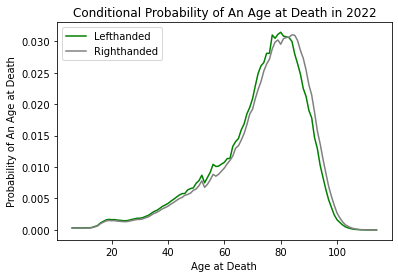

In [22]:
lh_prob = Prob_Age_given_lefthanded(age_range, death_rate, 2022)
rh_prob = Prob_Age_given_righthanded(age_range, death_rate, 2022)

lh_age =  np.nansum(age_range * np.array(lh_prob))
rh_age =  np.nansum(age_range * np.array(rh_prob))

print("The average age of left-handed individuals in 2022 is ",lh_age )
print("The average age of right-handed individuals in 2022 is ",rh_age)
print("The age difference  ", rh_age - lh_age,  " years.")

fig, ax = plt.subplots() 
ax.plot(age_range, lh_prob, label = "Lefthanded", color = 'Green')
ax.plot(age_range, rh_prob, label = 'Righthanded', color = 'Grey')
ax.set_xlabel("Age at Death")
ax.set_ylabel("Probability of An Age at Death")
ax.set_title("Conditional Probability of An Age at Death in 2022")
ax.legend() 

I decided to predict the average age of handed individuals in the year 2022, 10 year after the left-handed rates paper was published. We can see that over time, the average age difference in lefthanded and right handed individual decreases from 5 years to 1.65. I think this change can likely be attributed to more awareness and the increased availability of left-handed resources. I think one of the short-comings of the 1991 study is response bias. Since the majority of the world is right-handed, the responses received in the survey would heavily reflect this skewing the data. Left-handedness was demonized for a while in many cultures so this would have also affected responses. Overall, there doesn't seem to be a drastic difference in mortality between left-handed and right-handed individuals in this day.

I've decided to construct a plot of the predicted ages of death from 1910 to 2022. For each year between these two dates, I will calculate the age of death for lefthanded individuals. I will also do the same with right handed individuals to identify if they follow similar patterns. 

In [55]:
lh_ages = []
rh_ages = []
years = np.arange(1910, 2022, 1)
for i in years:
    avg_lh = Prob_Age_given_lefthanded(age_range, death_rate, i)
    lh_values =  np.nansum(age_range * np.array(avg_lh))
    lh_ages.append(lh_values)
    avg_rh = Prob_Age_given_righthanded(age_range, death_rate, i)
    rh_values =  np.nansum(age_range * np.array(avg_rh))
    rh_ages.append(rh_values)

df = pd.DataFrame(
    {'Years': years,
     'Lefthanded Age of Death': lh_ages,
     'Righthanded Age of Death': rh_ages,
    })
df.head()


    

,Years,Lefthanded Age of Death,Righthanded Age of Death
0,1910,73.219501,73.216207
1,1911,73.204043,73.217195
2,1912,73.199274,73.217500
3,1913,73.202408,73.217299
4,1914,73.199852,73.217463


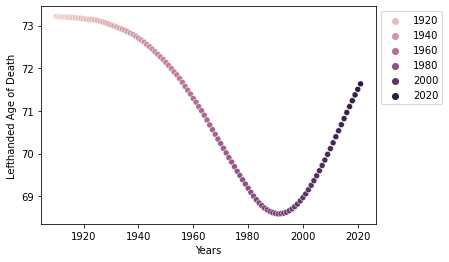

In [63]:
sns.scatterplot(x ='Years',y = 'Lefthanded Age of Death', hue = 'Years', alpha = 1, data = df)
plt.legend(bbox_to_anchor = (1.0, 1), loc = 2)

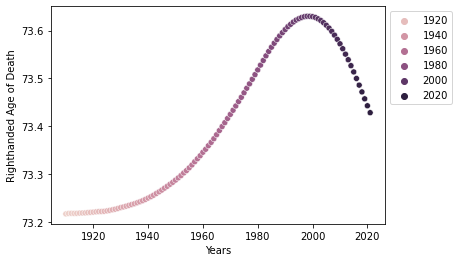

In [64]:
sns.scatterplot(x ='Years',y = 'Righthanded Age of Death', hue = 'Years', alpha = 1, data = df)
plt.legend(bbox_to_anchor = (1.0, 1), loc = 2)

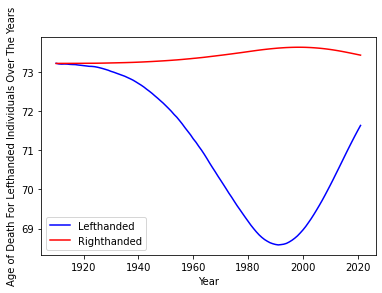

In [56]:
fig, ax = plt.subplots() 
ax.plot(years, lh_ages, label = "Lefthanded", color = 'Blue')
ax.plot(years, rh_ages, label = "Righthanded", color = 'Red')
ax.set_xlabel("Year")
ax.set_ylabel("Age of Death For Lefthanded Individuals Over The Years")
ax.legend() 

The dip between 1980 and 2000 for lefthanded individuals is interesting. Considering in the early 1990s, the survey about lefthanded mortality was sent to the public. While this dip would call for further research into circumstances that may have affected lefthanded individuals between this time period, I'm lead to hypothesize that the critical responses to the initial survey were on the right track. It seems there may have been some bias during the survey collection. I do feel that considering the righthanded centric world, this is still an interesting topic to dive further into. 

##### Sources
[1] CJ;, Gilbert AN;Wysocki. “Hand Preference and Age in the United States.” Neuropsychologia, U.S. National Library of Medicine, https://pubmed.ncbi.nlm.nih.gov/1528408/. 

[2] “NVSS - Mortality Tables.” Centers for Disease Control and Prevention, Centers for Disease Control and Prevention, 16 Dec. 2016, https://www.cdc.gov/nchs/nvss/mortality_tables.htm. 
